## Simple Introduction to DFlat and It's Workflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import gc
from dflat.initialize import focusing_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model
from dflat.plot_utilities import mp_format
from dflat.propagation import PointSpreadFunction

(1, 1, 257, 257) (1, 1, 257, 257) (1, 1, 257, 257)


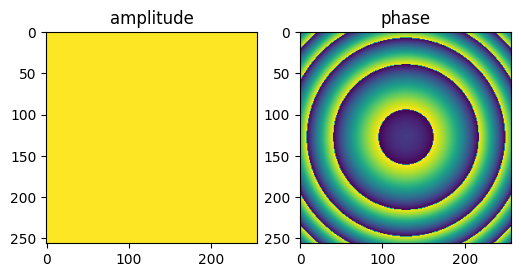

In [3]:
amp, phase, aperture = focusing_lens(
    in_size=[257,257],
    in_dx_m=[300e-9, 300e-9],
    wavelength_set_m=[600e-9],
    depth_set_m=[1e-3],
    fshift_set_m=[[0.0, 0.0]],
    out_distance_m=1e-3,
    aperture_radius_m=None,
    radial_symmetry=False
)
# returns focusing profiles of shape [Z, Lam, H, W]
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0,0]*aperture[0,0], vmin=0, vmax=1)
ax[0].set_title("amplitude")
ax[1].imshow(phase[0,0])
ax[1].set_title("phase");

Target Module: dflat.metasurface.optical_model.NeuralCells
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint /home/deanhazineh/Research/Dflat-pytorch-private_version2/dflat/metasurface/ckpt/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys
Target Module: dflat.metasurface.optical_model.NeuralCells
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint /home/deanhazineh/Research/Dflat-pytorch-private_version2/dflat/metasurface/ckpt/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


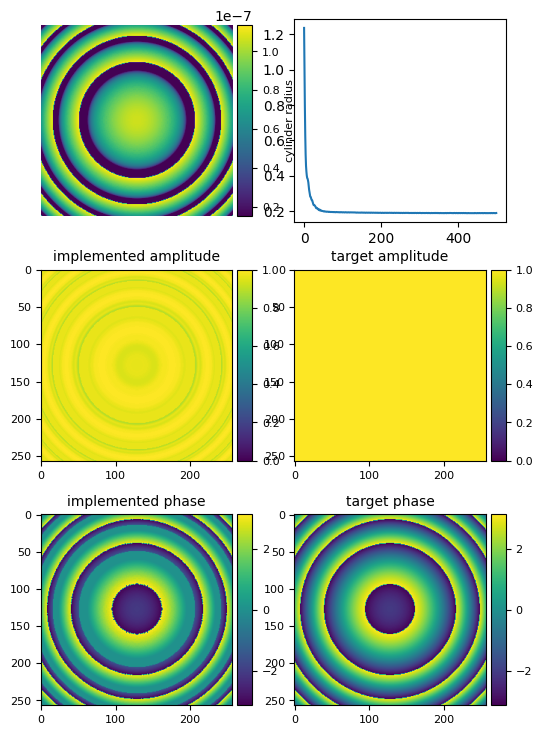

In [5]:
# Reverse look-up to find the metasurface that implements the target profile
model_config_path = "metasurface/ckpt/Nanocylinders_TiO2_U300H600/config.yaml"
p_norm, p, err = reverse_lookup_optimize(
    np.expand_dims(amp,0),
    np.expand_dims(phase,0),
    [600e-9],
    model_config_path,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,)

# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_config_path)
model = model.to("cuda")

est_amp, est_phase = model(p, np.array([600e-9]), pre_normalized=False)
est_amp = est_amp.cpu().numpy()
est_phase = est_phase.cpu().numpy()

fig, ax = plt.subplots(3,2, figsize=(6,9))
ax[0,0].imshow(p.squeeze())
mp_format.formatPlot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder radius")
ax[0,0].axis('off')
ax[0,1].plot(err)
ax[1,0].imshow(est_amp.squeeze(), vmin=0, vmax=1)
mp_format.formatPlot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp.squeeze(), vmin=0, vmax=1)
mp_format.formatPlot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")
ax[2,0].imshow(est_phase.squeeze())
mp_format.formatPlot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase.squeeze())
mp_format.formatPlot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

In [8]:
# Compute the point-spread function for this lens for different conditions
PSF = PointSpreadFunction(
    in_size=[257, 257],
    in_dx_m=[300e-9, 300e-9],
    out_distance_m=1e-3,
    out_size=[512, 512],
    out_dx_m=[500e-9, 500e-9],
    out_resample_dx_m=None,
    radial_symmetry=False,
    diffraction_engine="ASM")

ps_locs = [[0.0, 0.0, 5e-4], [0.0, 0.0, 1e-3], [0.0, 0.0, 5e-3]]
sim_wl = [500e-9, 600e-9, 700e-9]

intensity, phase = PSF(
    torch.tensor(est_amp, dtype=torch.float32, device='cuda'),
    torch.tensor(est_phase, dtype=torch.float32, device='cuda'),
    sim_wl,
    ps_locs,
    aperture=None,
    normalize_to_aperture=True)
intensity = intensity.cpu().numpy()
phase = phase.cpu().numpy()

torch.Size([1, 1, 257, 257]) torch.Size([1, 1, 257, 257])


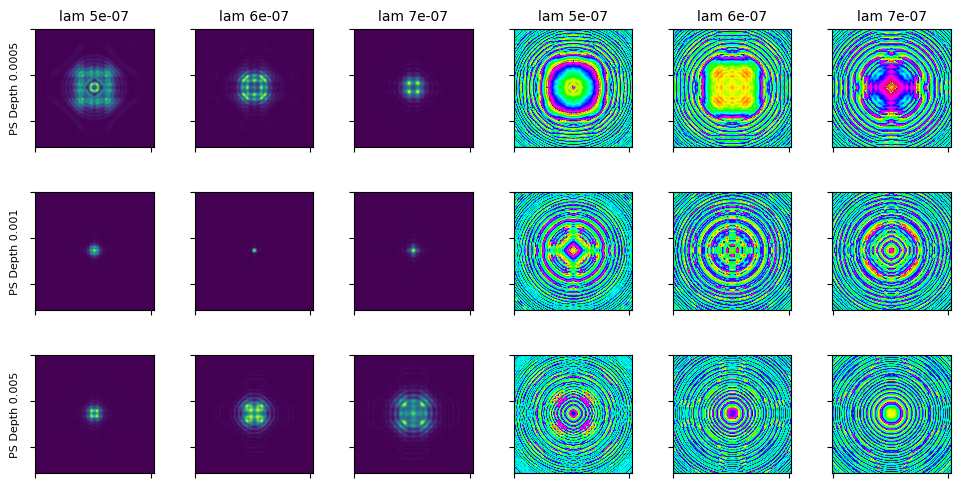

In [9]:
fig, ax = plt.subplots(3, 6, figsize=(12,6))
for z in range(3):
    for l in range(3):
        ax[z,l].imshow(intensity[0,0, z, l,:,:])
        mp_format.formatPlot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
        
    for l in np.arange(3,6,1):
        ax[z,l].imshow(phase[0,0, z, l-3,:,:], cmap='hsv')
        mp_format.formatPlot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l-3]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
    ax[z,0].set_ylabel(f"PS Depth {ps_locs[z][2]}")

In [10]:
# Write this lens to a gds file for fabrication
pfab = p.squeeze(0)
mask = np.ones(pfab.shape[0:2])
cell_size = [300e-9, 300e-9]
block_size =[300e-9, 300e-9] # This can be used to repeat the cell as a larger block

from dflat.GDSII.assemble import assemble_nanocylinder_gds
assemble_nanocylinder_gds(pfab, mask, cell_size, block_size, savepath="./file.gds")

/home/deanhazineh/anaconda3/envs/dflat_pytorch_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Writing metasurface shapes to GDS File


100%|██████████| 257/257 [00:01<00:00, 133.02it/s]


Completed writing and saving metasurface GDS File: Time:  2.2489850521087646


## Explore some image rendering with metasurfaces

In [11]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [12]:
import matplotlib.pyplot as plt
import mat73
from scipy import interpolate
import numpy as np
import torch
from einops import rearrange

from dflat.initialize import focusing_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model
from dflat.propagation import PointSpreadFunction
from dflat.render import hsi_to_rgb
from dflat.plot_utilities import formatPlot
from dflat.render import Fronto_Planar_Renderer_Incoherent

In [14]:
settings = {
    "in_size": [513, 513],
    "in_dx_m": [10*300e-9, 10*300e-9],
    "wavelength_set_m": [550e-9],
    "depth_set_m": [1e-2],
    "fshift_set_m": [[0.0, 0.0]],
    "out_distance_m": 1e-2,
    "aperture_radius_m": None,
    "radial_symmetry": True
    }
amp, phase, aperture = focusing_lens(**settings)
print(amp.shape, phase.shape, aperture.shape)
#  Phase, and Aperture profiles of shape [Z, Lam, H, W]

# Reverse look-up to find the metasurface that implements the target profile
model_config_path = "metasurface/ckpt/Nanocylinders_TiO2_U300H600/config.yaml"
amp_ = amp[None]
phase_ = phase[None]
p_norm, p, err = reverse_lookup_optimize(
    amp_,
    phase_,
    [550e-9],
    model_config_path,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,)
print(p.shape)
# [B, H, W, D] where D is the number of shape parameters. 

# Predict the broadband phase and amplitude imparted by this collection of meta-atoms
model = load_optical_model(model_config_path)
model = model.to("cuda")
sim_wl = np.linspace(400e-9, 700e-9, 31)
est_amp, est_phase = model(p, sim_wl, pre_normalized=False)
print(est_amp.shape, est_phase.shape) 
# [B, pol, Lam, H, W] where pol is 1 or 2

# Compute the point spread function given this broadband stack of field amplitude and phases
PSF = PointSpreadFunction(
    in_size=[513, 513],
    in_dx_m=[10*300e-9, 10*300e-9],
    out_distance_m=1e-2,
    out_size=[512, 512],
    out_dx_m=[5e-6,5e-6],
    out_resample_dx_m=None,
    radial_symmetry=True,
    diffraction_engine="ASM")
ps_locs = [[0.0, 0.0, 1e-2]]

psf_intensity, _ = PSF(
    est_amp.to(dtype=torch.float32, device='cuda'),
    est_phase.to(dtype=torch.float32, device='cuda'),
    sim_wl,
    ps_locs,
    aperture=None,
    normalize_to_aperture=True)
print(psf_intensity.shape)
# shape [B P Z L H W]

(1, 1, 1, 257) (1, 1, 1, 257) (1, 1, 1, 257)
Target Module: dflat.metasurface.optical_model.NeuralCells
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint /home/deanhazineh/Research/Dflat-pytorch-private_version2/dflat/metasurface/ckpt/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys
(1, 1, 257, 1)
Target Module: dflat.metasurface.optical_model.NeuralCells
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint /home/deanhazineh/Research/Dflat-pytorch-private_version2/dflat/metasurface/ckpt/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys
torch.Size([1, 1, 31, 1, 257]) torch.Size([1, 1, 31, 1, 257])
torch.Size([1, 31, 1, 257]) torch.Size([1, 31, 1, 257])


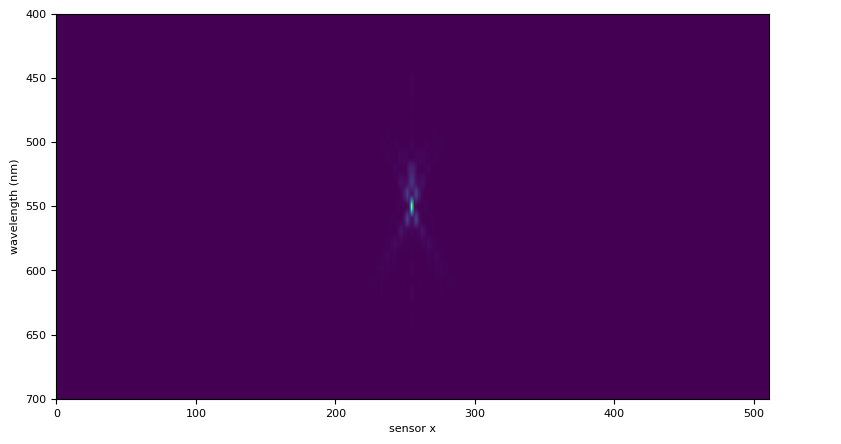

In [15]:
# Display a slice of the radially symmetric point-spread function we will use
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(psf_intensity[0,0,0,:,256,:].cpu().numpy())
formatPlot(fig, ax, ylabel="wavelength (nm)", xlabel="sensor x", yvec=sim_wl*1e9, xvec = np.arange(0,512,1), setAspect="auto")


(482, 512, 31) torch.Size([482, 512, 3])


Text(0.5, 1.0, 'HSI Projected to RGB')

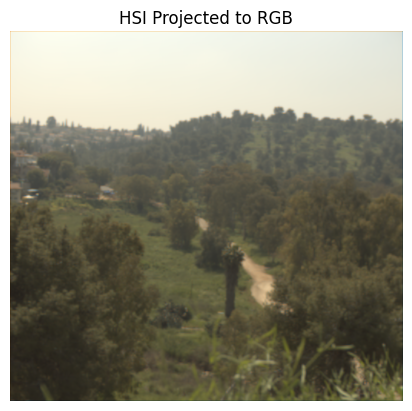

In [16]:
# Load a hyperspectral image for rendering

def load_mat_dat(path):
    # Note: not sure what norm_factor is used for
    # Investigate or in the future add a note once identified
    # Upon inspection, bands are provided in units of nm and range from 400 to 700 nm for Arad1k
    # with a 10 nm step size
    mat_dat = mat73.loadmat(path)
    bands = mat_dat["bands"]
    cube = mat_dat["cube"]
    _ = mat_dat["norm_factor"]
    return bands, cube


def interpolate_HS_Cube(new_channels_nm, hs_cube, hs_bands):
    # Throw an error if we try to extrapolate
    if (min(new_channels_nm) < min(hs_bands) - 1) or (
        max(new_channels_nm) > max(hs_bands) + 1
    ):
        raise ValueError(
            f"In generator, extrapoaltion of the ARAD dataset outside of measurement data is not allowed: {min(hs_bands)}-{max(hs_bands)}"
        )

    interpfun = interpolate.interp1d(
        hs_bands,
        hs_cube,
        axis=-1,
        kind="linear",
        assume_sorted=True,
        fill_value="extrapolate",
        bounds_error=False,
    )
    resampled = interpfun(new_channels_nm)

    return resampled

# Load hyperspectral data cube needed for rendering
sim_wl = np.linspace(400e-9, 700e-9, 31)
bands, cube = load_mat_dat("./ARAD_1K_0001.mat")
hsi_data = interpolate_HS_Cube(sim_wl*1e9, cube, bands)
hsi_data = np.clip(hsi_data, 0, 1)
rgb_img = hsi_to_rgb(hsi_data[None], sim_wl)[0]
print(hsi_data.shape, rgb_img.shape)

fig, ax  = plt.subplots(1,1)
ax.imshow(rgb_img)
ax.axis('off')
ax.set_title("HSI Projected to RGB")

torch.Size([1, 1, 1, 31, 512, 512]) torch.Size([1, 1, 1, 31, 482, 512])
torch.Size([1, 1, 1, 3, 482, 512]) torch.Size([1, 1, 1, 1, 482, 512])


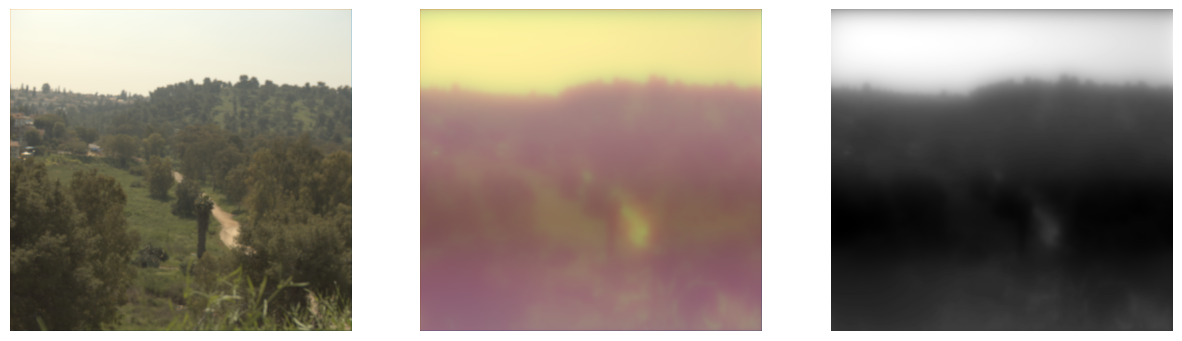

In [17]:
renderer = Fronto_Planar_Renderer_Incoherent()
# Need to pass inputs like
# psf has shape  [B P Z L H W]
# scene radiance [1 P Z L H W]
hsi_cube = rearrange(hsi_data, "H W C -> C H W")[None, None, None]
hsi_cube = torch.tensor(hsi_cube, dtype=torch.float32, device='cuda')
psf_intensity = psf_intensity.to('cuda')
print(psf_intensity.shape, hsi_cube.shape)

out_int = renderer(psf_intensity, hsi_cube, rfft=True, crop_to_psf_dim=False)
meas_rgb = renderer.rgb_measurement(out_int, sim_wl, gamma=True, bayer_mosaic=True)
meas_gs = torch.sum(out_int, -3, keepdim=True)
print(meas_rgb.shape, meas_gs.shape)

# Displayed the RGB measurement after the metasurface
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(rgb_img)
ax[1].imshow(np.transpose(meas_rgb[0,0,0].cpu().numpy(), [1,2,0]))
ax[2].imshow(meas_gs[0,0,0,0].cpu().numpy(), cmap='gray')
[axi.axis('off') for axi in ax.flatten()];
